# Configuración Inicial

In [1]:
import sys
import os

def setup_workdirectory(
    repo_url="https://github.com/kikaymusic/EscuderoRodriguezSanchez.git",
    branch="dev",
    repo_name="EscuderoRodriguezSanchez",
    directoy_name="Entornos_Complejos"
):
    """
    Función para detectar si el código se está ejecutando en Google Colab o en local
    y configurar el entorno de trabajo en consecuencia.
    """
    # Detectamos si estamos en Google Colab
    in_colab = "google.colab" in sys.modules

    if in_colab:
        print("Entorno detectado: Google Colab")

        # Definimos la ruta del repositorio en Colab
        repo_path = f"/content/{repo_name}"

        # Borramos el repositorio si ya existe para evitar conflictos
        if os.path.exists(repo_path):
            os.system(f"rm -rf {repo_path}")

        # Clonamos la rama especificada del repositorio
        os.system(f"git clone -b {branch} --single-branch {repo_url}")

        # Cambiamos al directorio del repositorio
        os.system(f"%cd {repo_path}")

        # Añadimos el directorio especificado al path
        sys.path.append(f'/content/{repo_name}/{directoy_name}')

    else:
        print("Entorno detectado: Local")

        # Añadir el directorio especificado al path de Python
        notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
        k_brazos_dir = notebook_dir if directoy_name in notebook_dir else os.path.join(notebook_dir, directoy_name)
        if k_brazos_dir not in sys.path:
            sys.path.insert(0, k_brazos_dir)


setup_workdirectory()

Entorno detectado: Local


# Imports

In [2]:
import gymnasium as gym
from src.train import train_agent
from src.agents.montecarlo import AgentMonteCarlo
from src.utils import SEMILLA
from src.policies.epsilon_greedy import EpsilonGreedyPolicy
from src.policies.epsilon_soft import EpsilonSoftPolicy
from src.utils import q_to_v_and_policy
from src.UI import evaluate_agent_visual
#import matplotlib.pyplot as plt
from src.plots import (
    plot_blackjack_values,
    plot_policy,
    plot_q_heatmap,
    plot_rewards,
    capture_figure,
    compare_plots
)

# Blackjack con Agente Monte Carlo Off-Policy

## Entorno Blackjack para tipo Tabular (Espacio de estados discreto) off-policy

En Off-policy, la Política de Comportamiento es distinta a la Política Objetivo. El agente genera experiencia moviéndose por el entorno de una forma (explorando mucho), pero actualiza sus valores asumiendo que está siguiendo una política completamente diferente (generalmente, una política 100% óptima o Greedy).

En On-policy, la Política de Comportamiento es exactamente la misma que la Política Objetivo. El agente aprende el valor de la política que está utilizando actualmente para tomar decisiones.

In [3]:
env = gym.make("Blackjack-v1", render_mode="rgb_array", sab=True)

# Inicializamos la política con la semilla
behavior_policy_off = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)  # Política epsilon-greedy para el entrenamiento
target_policy_off = EpsilonGreedyPolicy(epsilon=0.0, n_actions=env.action_space.n, seed=SEMILLA)  # Política full-greedy

# El agente usa las políticas
agent_off = AgentMonteCarlo(env, target_policy_off, behavior_policy_off)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [5]:
results_before_off = evaluate_agent_visual(
    env, agent_off,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_off)

{'wins': 1, 'losses': 8, 'draws': 1, 'win_rate': 10.0, 'episodes': 10}


## Entrenamiento del Agente

In [6]:
episode_returns_off, episode_lengths_off = train_agent(env, agent_off)

Episode 5000/80000 - avg_return_last_5000=-0.1436
Episode 10000/80000 - avg_return_last_5000=-0.1428
Episode 15000/80000 - avg_return_last_5000=-0.1420
Episode 20000/80000 - avg_return_last_5000=-0.1362
Episode 25000/80000 - avg_return_last_5000=-0.1138
Episode 30000/80000 - avg_return_last_5000=-0.1204
Episode 35000/80000 - avg_return_last_5000=-0.0998
Episode 40000/80000 - avg_return_last_5000=-0.0986
Episode 45000/80000 - avg_return_last_5000=-0.1028
Episode 50000/80000 - avg_return_last_5000=-0.1128
Episode 55000/80000 - avg_return_last_5000=-0.1106
Episode 60000/80000 - avg_return_last_5000=-0.0662
Episode 65000/80000 - avg_return_last_5000=-0.0880
Episode 70000/80000 - avg_return_last_5000=-0.1012
Episode 75000/80000 - avg_return_last_5000=-0.0994
Episode 80000/80000 - avg_return_last_5000=-0.0952


## Resultados y Análisis

### Tendencia de recompensas

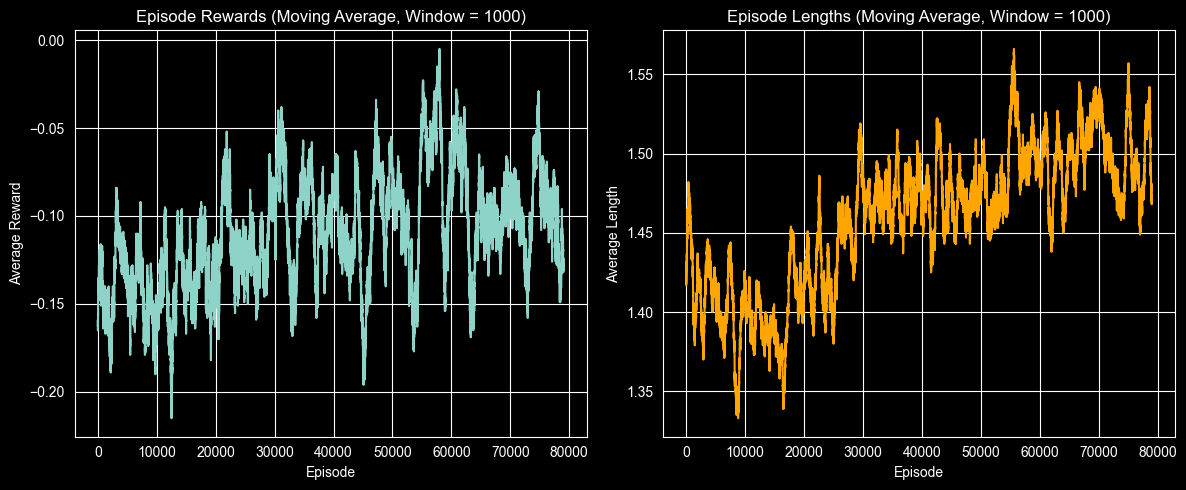

In [7]:
# 1) Reward trend (moving average)
plot_rewards(episode_returns_off, episode_lengths_off, window=1000)

Tendencia de recompensa media

---

Esta figura muestra la evolución de la recompensa media por episodio usando una media móvil (ventana de 1000 episodios). En este entorno del Blackjack, la recompensa final del agente suele tomar valores discretos (+1 si se gana, 0 si se empata y -1 si se pierde), por lo que la media móvil permite observar mejor la tendencia general y reducir el ruido de episodios individuales.

En este caso, la curva se mantiene en valores negativos durante gran parte del entrenamiento, lo que indica que el agente todavía pierde más partidas de las que gana en promedio. Aun así, las oscilaciones y tramos de mejora sugieren que la política sí está cambiando con el aprendizaje. Este comportamiento es razonable en Blackjack, ya que el entorno tiene componente aleatoria y existe ventaja estructural del dealer.


Tendencia de la longitud media del episodio

---

Esta figura representa la longitud media del episodio (número de decisiones por partida) mediante una media móvil. En Blackjack, esta métrica suele situarse en valores bajos (alrededor de 1-2 acciones por episodio), ya que cada partida termina tras pocas decisiones del jugador.

Aunque no mide directamente el rendimiento, esta gráfica es útil como indicador complementario del aprendizaje, porque refleja cambios en el patrón de comportamiento del agente. Por ejemplo, una variación en la longitud media puede indicar que el agente está pidiendo carta con mayor o menor frecuencia (`HIT`) según evoluciona la política.

En este sentido, la longitud del episodio actúa como una señal indirecta de que la estrategia aprendida se está modificando, incluso cuando la recompensa media sigue siendo ruidosa.


### Superficie de Valores de Estado

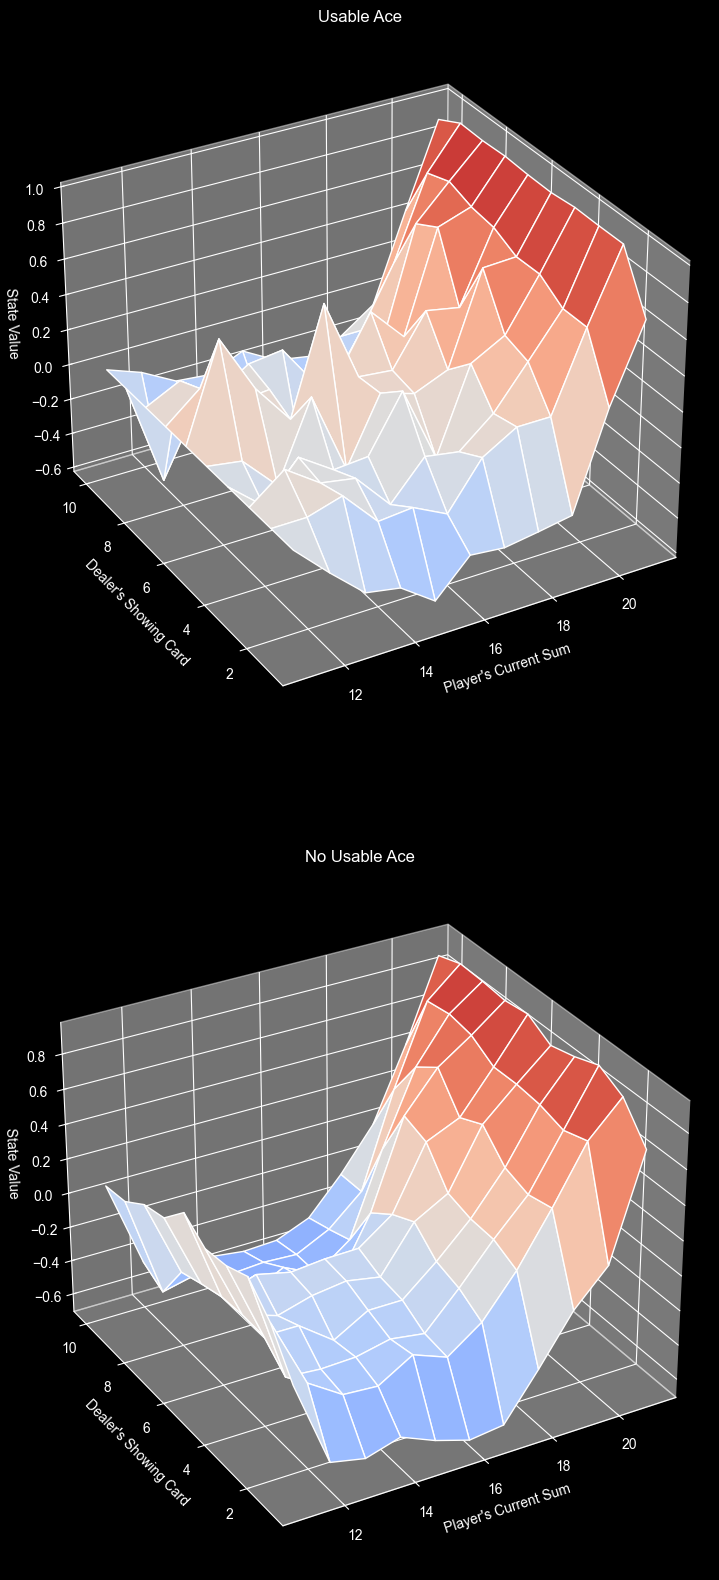

In [8]:
# 3) Value function + policy visualization
V_off, policy_off = q_to_v_and_policy(agent_off.q_table)
plot_blackjack_values(V_off)

Superficie de valores de estado

---

Esta visualización representa la función de valor de estado $V(s)$ derivada de la tabla de valores de acción $Q(s,a)$ aprendida por el agente. Matemáticamente, se calcula como $V(s) = \max_a Q(s,a)$, lo que indica el retorno esperado si el agente se encuentra en un estado específico y, a partir de ahí, sigue siempre la política óptima (greedy).

**Anatomía de la gráfica:**
- **Eje X:** Suma actual de las cartas del jugador (rango de 11 a 21).
- **Eje Y:** Carta visible del crupier (de 1 a 10).
- **Eje Z:** Valor estimado del estado (rango entre -1.0 y +1.0).

**Interpretación de los resultados:**
- **Zonas favorables (Picos):** Se observan valores altos (cercanos a +1.0) en estados donde el jugador tiene sumas elevadas (19, 20 o 21). Esto es coherente con la mecánica del Blackjack, ya que plantarse en estos estados garantiza casi siempre la victoria o el empate.
- **Zonas desfavorables (Valles):** Los valores fuertemente negativos predominan en estados "incómodos" (sumas entre 12 y 16), reflejando una alta probabilidad de perder sin importar la acción elegida, especialmente frente a cartas fuertes del crupier.

**Impacto del As Usable:**
La figura se divide en dos gráficas que muestran diferencias importantes no solo por la mecánica del juego, sino por la convergencia del algoritmo:
1. **No Usable Ace:** Esta superficie tiende a mostrarse más definida y suave empíricamente. Al ser estados muy comunes en el Blackjack, el agente los visita con alta frecuencia, permitiendo que la estimación de valor converja y muestre claramente los "valles" de riesgo profundo (sumas entre 12 y 16 frente a cartas fuertes del dealer).
2. **Usable Ace:** Aunque teóricamente el As actúa como una red de seguridad (disminuyendo el riesgo de pasarse), en la gráfica se observan más picos y rugosidades. Esto es un reflejo directo de la **escasez de datos**: los estados con As usable ocurren con mucha menor frecuencia. Al tener menos visitas, las estimaciones en estos estados tienen mayor varianza estocástica y no han convergido completamente, reflejando el "ruido" de episodios puntuales.

### Mapa de Política Aprendida

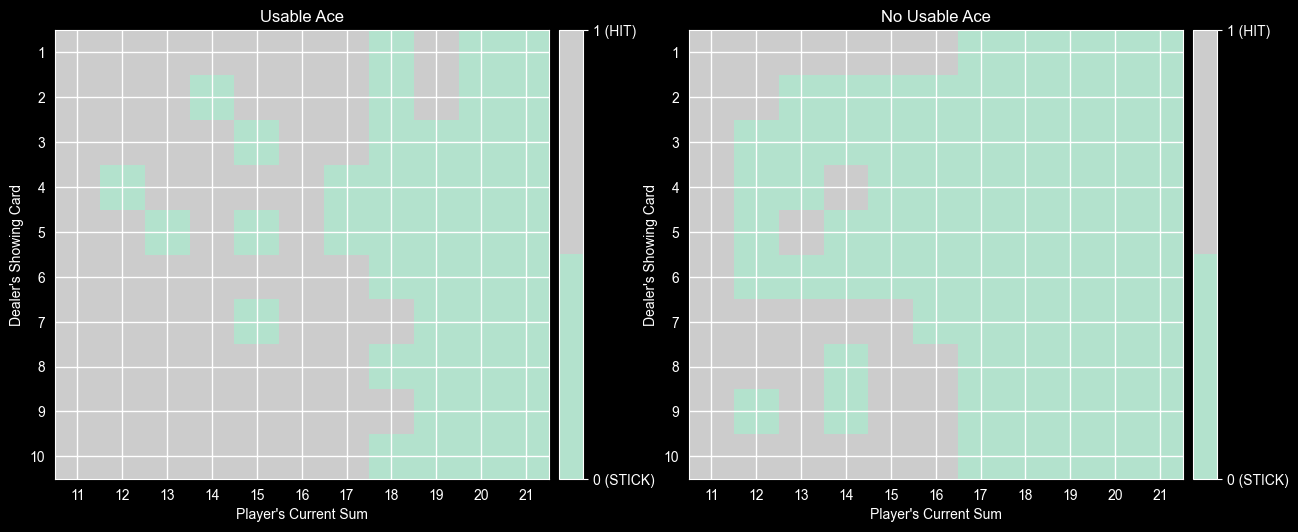

In [9]:
plot_policy(policy_off)

Esta figura representa la política *greedy* $\pi(s)$ aprendida por el agente; es decir, la acción determinista seleccionada en cada estado en función de maximizar los valores de acción $Q(s,a)$.

**Leyenda de Acciones:**
- `0 = STICK` (Plantarse)
- `1 = HIT` (Pedir carta)

**Anatomía de la Gráfica:**
- **Eje X:** Suma actual de las cartas del jugador.
- **Eje Y:** Carta visible del crupier.
- La visualización se presenta separada para estados con `Usable Ace` y `No Usable Ace`, ya que la presencia del As modifica drásticamente la frontera de decisión óptima.

**Interpretación de la Estrategia:**
La figura permite interpretar de forma visual la estrategia adquirida por el agente, revelando un patrón de comportamiento lógico:
- **Sumas altas (17-21):** Predomina claramente la acción de plantarse (`STICK`), ya que el riesgo de pasarse (*bust*) es demasiado alto.
- **Sumas bajas o intermedias (12-16):** La frontera de decisión depende fuertemente de la carta del crupier. Aparece con mayor frecuencia la acción de pedir carta (`HIT`), especialmente cuando la situación es desfavorable (el crupier muestra cartas altas como 7, 8, 9 o 10). Por el contrario, si el crupier muestra cartas "débiles" (ej. 4, 5, 6), el agente tiende a plantarse antes para dejar que sea el crupier quien asuma el riesgo de pasarse.

### Distribución de Q-Valores por Acción dado un Estado

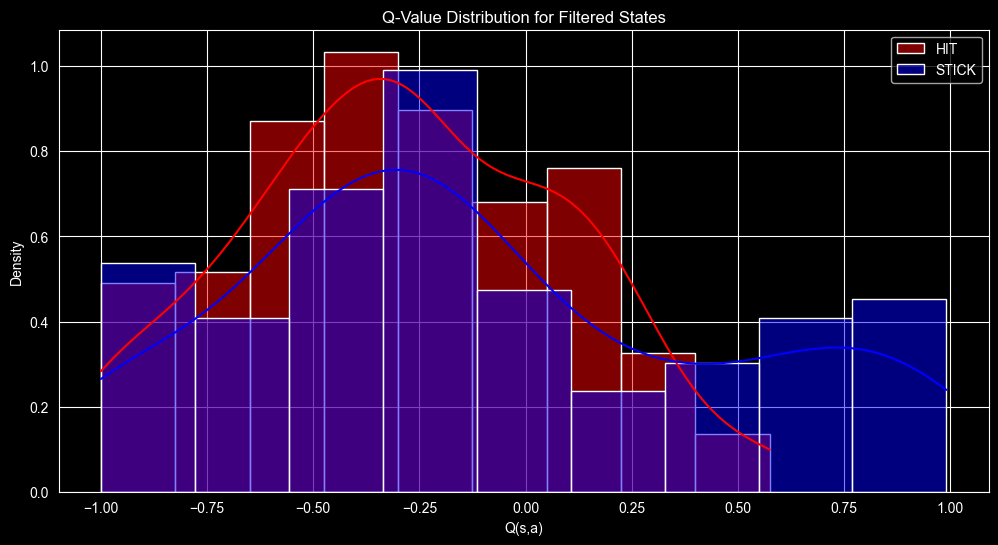

In [10]:
# 4) Extra: distribución de Q(s,a) en estados típicos (player sum 11..21)
plot_q_heatmap(
    agent_off.q_table,
    state_filter_fn=lambda s: (isinstance(s, tuple) and len(s) == 3 and 11 <= s[0] <= 21),
   
)

Distribución de valores Q por acción 

---

Aunque el nombre de la función indica "heatmap", esta visualización corresponde a un histograma (con curvas suavizadas en algunos casos) de la distribución de valores `Q(s,a)` para las dos acciones (`HIT` y `STICK`) en un subconjunto de estados filtrados.

En este experimento, se han considerado estados con suma del jugador entre 11 y 21. La figura permite comparar cómo se distribuyen los valores estimados para cada acción y observar si existe separación clara entre ambas o si hay mucho solapamiento.

El solapamiento entre distribuciones es esperable en Blackjack, ya que en muchos estados las dos acciones pueden tener valores relativamente próximos. Esta gráfica resulta útil para analizar la estabilidad de la estimación de `Q` y para entender en qué medida una acción está siendo preferida sobre la otra en distintos rangos de estados.


## Visualización Gráfica

In [11]:
results_after_off = evaluate_agent_visual(
    env, agent_off,
    n_episodes=10,
    seed_base=SEMILLA + 10000,
    delay=0.2,
    greedy_eval=True
)
print(results_after_off)

{'wins': 6, 'losses': 4, 'draws': 0, 'win_rate': 60.0, 'episodes': 10}


# Blackjack con Agente Monte Carlo On-Policy

## Entorno Blackjack para tipo Tabular (Espacio de estados discreto) on-policy

En Off-policy, la Política de Comportamiento es distinta a la Política Objetivo. El agente genera experiencia moviéndose por el entorno de una forma (explorando mucho), pero actualiza sus valores asumiendo que está siguiendo una política completamente diferente (generalmente, una política 100% óptima o Greedy).

En On-policy, la Política de Comportamiento es exactamente la misma que la Política Objetivo. El agente aprende el valor de la política que está utilizando actualmente para tomar decisiones.

In [12]:
#env = gym.make("Blackjack-v1", render_mode="rgb_array", sab=True)

# Inicializamos la política con la semilla
target_policy_on = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)  # Política full-soft
#behavior_policy_on = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)  # Política epsilon-soft para el entrenamiento

# El agente usa las políticas
agent_on = AgentMonteCarlo(env, target_policy_on, None)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [13]:

print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [14]:
results_before_on = evaluate_agent_visual(
    env, agent_on,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_on)

{'wins': 2, 'losses': 7, 'draws': 1, 'win_rate': 20.0, 'episodes': 10}


## Entrenamiento del Agente

In [15]:
episode_returns_on, episode_lengths_on = train_agent(env, agent_on)

Episode 5000/80000 - avg_return_last_5000=-0.1682
Episode 10000/80000 - avg_return_last_5000=-0.1228
Episode 15000/80000 - avg_return_last_5000=-0.1330
Episode 20000/80000 - avg_return_last_5000=-0.1306
Episode 25000/80000 - avg_return_last_5000=-0.1268
Episode 30000/80000 - avg_return_last_5000=-0.1188
Episode 35000/80000 - avg_return_last_5000=-0.1202
Episode 40000/80000 - avg_return_last_5000=-0.1384
Episode 45000/80000 - avg_return_last_5000=-0.1124
Episode 50000/80000 - avg_return_last_5000=-0.1222
Episode 55000/80000 - avg_return_last_5000=-0.1124
Episode 60000/80000 - avg_return_last_5000=-0.0924
Episode 65000/80000 - avg_return_last_5000=-0.1106
Episode 70000/80000 - avg_return_last_5000=-0.1222
Episode 75000/80000 - avg_return_last_5000=-0.1088
Episode 80000/80000 - avg_return_last_5000=-0.1126


## Resultados y Análisis

### Tendencia de recompensas

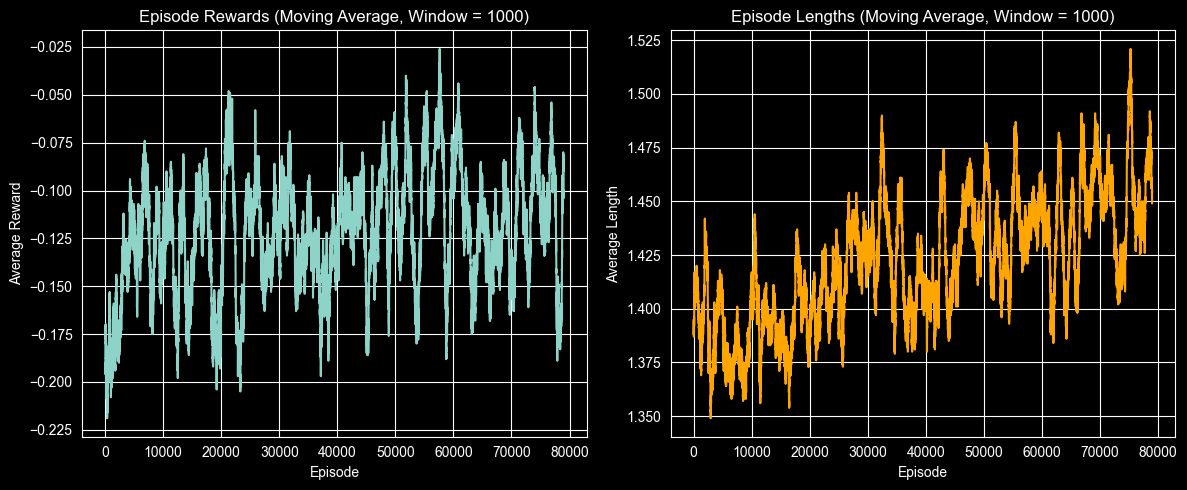

In [16]:
# Suponiendo que tienes las listas
plot_rewards(episode_returns_on, episode_lengths_on, window=1000)

Tendencia de recompensa media

---

Esta figura muestra la evolución de la recompensa media por episodio usando una media móvil (ventana de 1000 episodios). En Blackjack, la recompensa final suele tomar valores discretos (+1 si se gana, 0 si se empata y -1 si se pierde), por lo que la media móvil permite observar mejor la tendencia general y reducir el ruido de episodios individuales.

En este caso, la curva se mantiene en valores negativos durante gran parte del entrenamiento, lo que indica que el agente todavía pierde más partidas de las que gana en promedio. Aun así, las oscilaciones y tramos de mejora sugieren que la política sí está cambiando con el aprendizaje. Este comportamiento es razonable en Blackjack, ya que el entorno tiene componente aleatoria y existe ventaja estructural del dealer.


Tendencia de recompensas en función de longitud de episodio

---

Esta figura representa la longitud media del episodio (número de decisiones por partida) mediante una media móvil. En Blackjack, esta métrica suele situarse en valores bajos (alrededor de 1-2 acciones por episodio), ya que cada partida termina tras pocas decisiones del jugador.

Aunque no mide directamente el rendimiento, esta gráfica es útil como indicador complementario del aprendizaje, porque refleja cambios en el patrón de comportamiento del agente. Por ejemplo, una variación en la longitud media puede indicar que el agente está pidiendo carta con mayor o menor frecuencia (`HIT`) según evoluciona la política.

En este sentido, la longitud del episodio actúa como una señal indirecta de que la estrategia aprendida se está modificando, incluso cuando la recompensa media sigue siendo ruidosa.


### Superficie de Valores de Estado

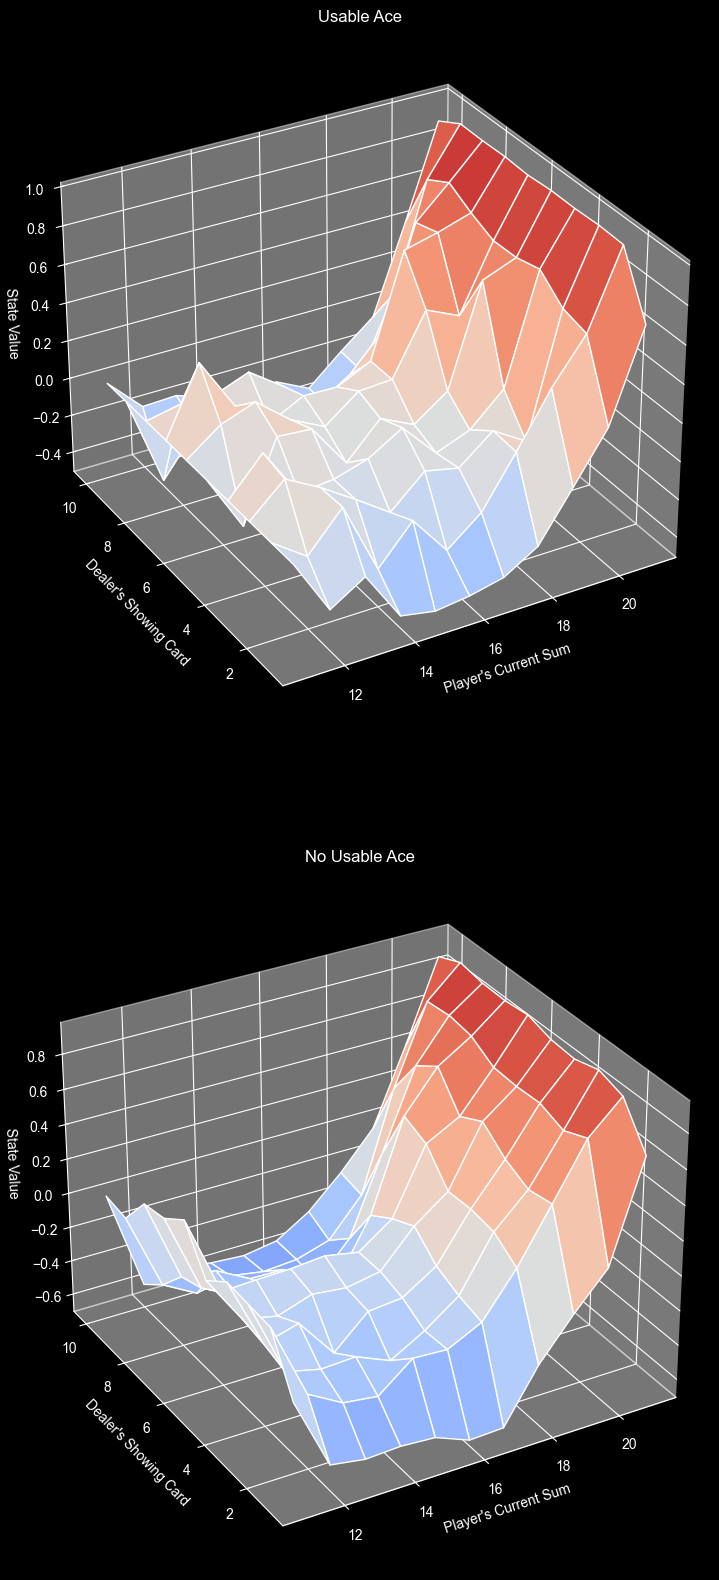

In [17]:
# 3) Value function + policy visualization
V_on, policy_on = q_to_v_and_policy(agent_on.q_table)
plot_blackjack_values(V_on)

Superficie de valores de estado

---

Esta visualización muestra la función de valor de estado `V(s)` derivada a partir de la tabla `Q(s,a)`. Cada punto de la superficie representa la calidad esperada de un estado (suma del jugador, carta visible del dealer y condición del as), asumiendo que el agente seguirá la política greedy aprendida.

- Eje X: suma actual del jugador.
- Eje Y: carta visible del dealer.
- Eje Z: valor estimado del estado.

Se observan valores más altos en estados con sumas elevadas (por ejemplo 19, 20 o 21), lo cual es coherente con la intuición del juego, ya que esas manos son generalmente favorables. En cambio, las zonas con valores negativos corresponden a estados más desfavorables, donde la probabilidad de perder es mayor.

La figura se divide en dos superficies (`Usable Ace` y `No Usable Ace`) porque la presencia de un as usable modifica de forma importante el riesgo y, por tanto, el valor esperado del estado.


### Mapa de Política Aprendida

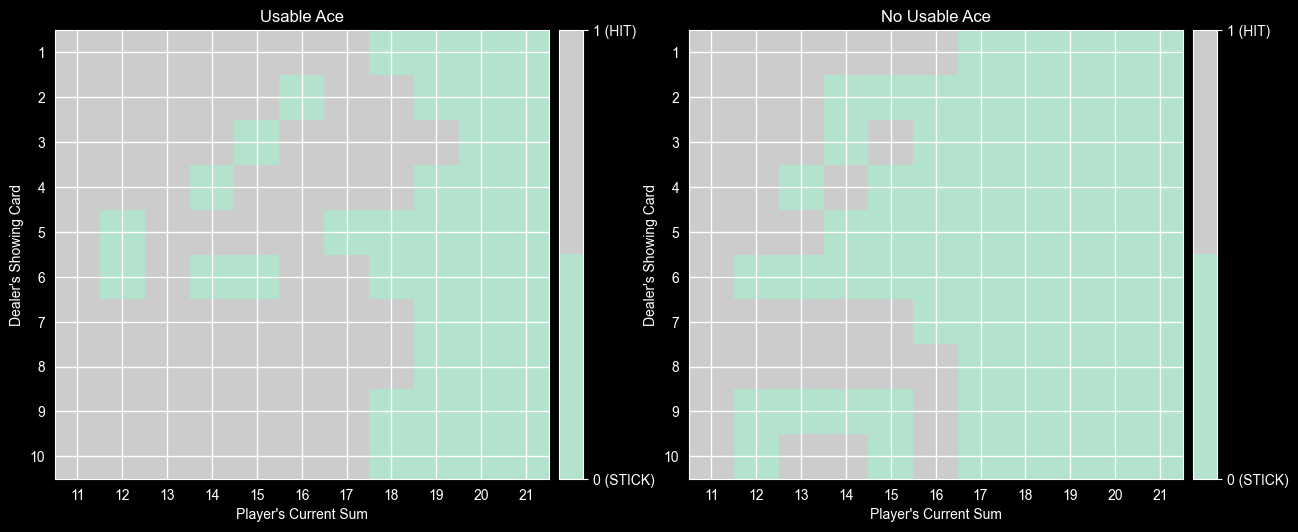

In [18]:
plot_policy(policy_on)

Mapa de política aprendida

---

Esta figura representa la política greedy aprendida por el agente, es decir, la acción seleccionada en cada estado en función de los valores `Q(s,a)`.

- `0 = STICK` (plantarse)
- `1 = HIT` (pedir carta)

Los ejes muestran la suma del jugador y la carta visible del dealer, y el color indica la acción elegida. La visualización se presenta separada para estados con `Usable Ace` y `No Usable Ace`, ya que la estrategia óptima cambia según esta condición.

La figura permite interpretar de forma clara la estrategia aprendida: en sumas altas suele predominar `STICK`, mientras que en sumas bajas o intermedias aparece con más frecuencia `HIT`, especialmente cuando la situación es menos favorable frente a la carta visible del dealer.


### Distribución de Q-Valores por Acción dado un Estado

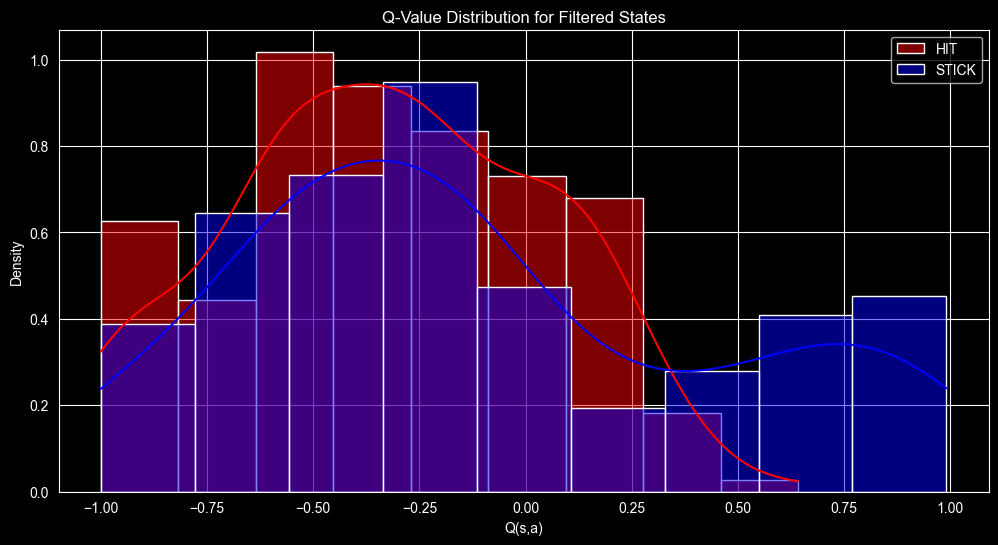

In [19]:
# 4) Extra: distribución de Q(s,a) en estados típicos (player sum 11..21)
plot_q_heatmap(
    agent_on.q_table,
    state_filter_fn=lambda s: (isinstance(s, tuple) and len(s) == 3 and 11 <= s[0] <= 21),
   
)

Distribución de valores Q por acción 

---

Aunque el nombre de la función indica "heatmap", esta visualización corresponde a un histograma (con curvas suavizadas en algunos casos) de la distribución de valores `Q(s,a)` para las dos acciones (`HIT` y `STICK`) en un subconjunto de estados filtrados.

En este experimento, se han considerado estados con suma del jugador entre 11 y 21. La figura permite comparar cómo se distribuyen los valores estimados para cada acción y observar si existe separación clara entre ambas o si hay mucho solapamiento.

El solapamiento entre distribuciones es esperable en Blackjack, ya que en muchos estados las dos acciones pueden tener valores relativamente próximos. Esta gráfica resulta útil para analizar la estabilidad de la estimación de `Q` y para entender en qué medida una acción está siendo preferida sobre la otra en distintos rangos de estados.


## Visualización Gráfica

In [20]:
results_after_on = evaluate_agent_visual(
    env, agent_on,
    n_episodes=10,
    seed_base=SEMILLA + 10000,
    delay=0.2,
    greedy_eval=True
)
print(results_after_on)

{'wins': 5, 'losses': 5, 'draws': 0, 'win_rate': 50.0, 'episodes': 10}


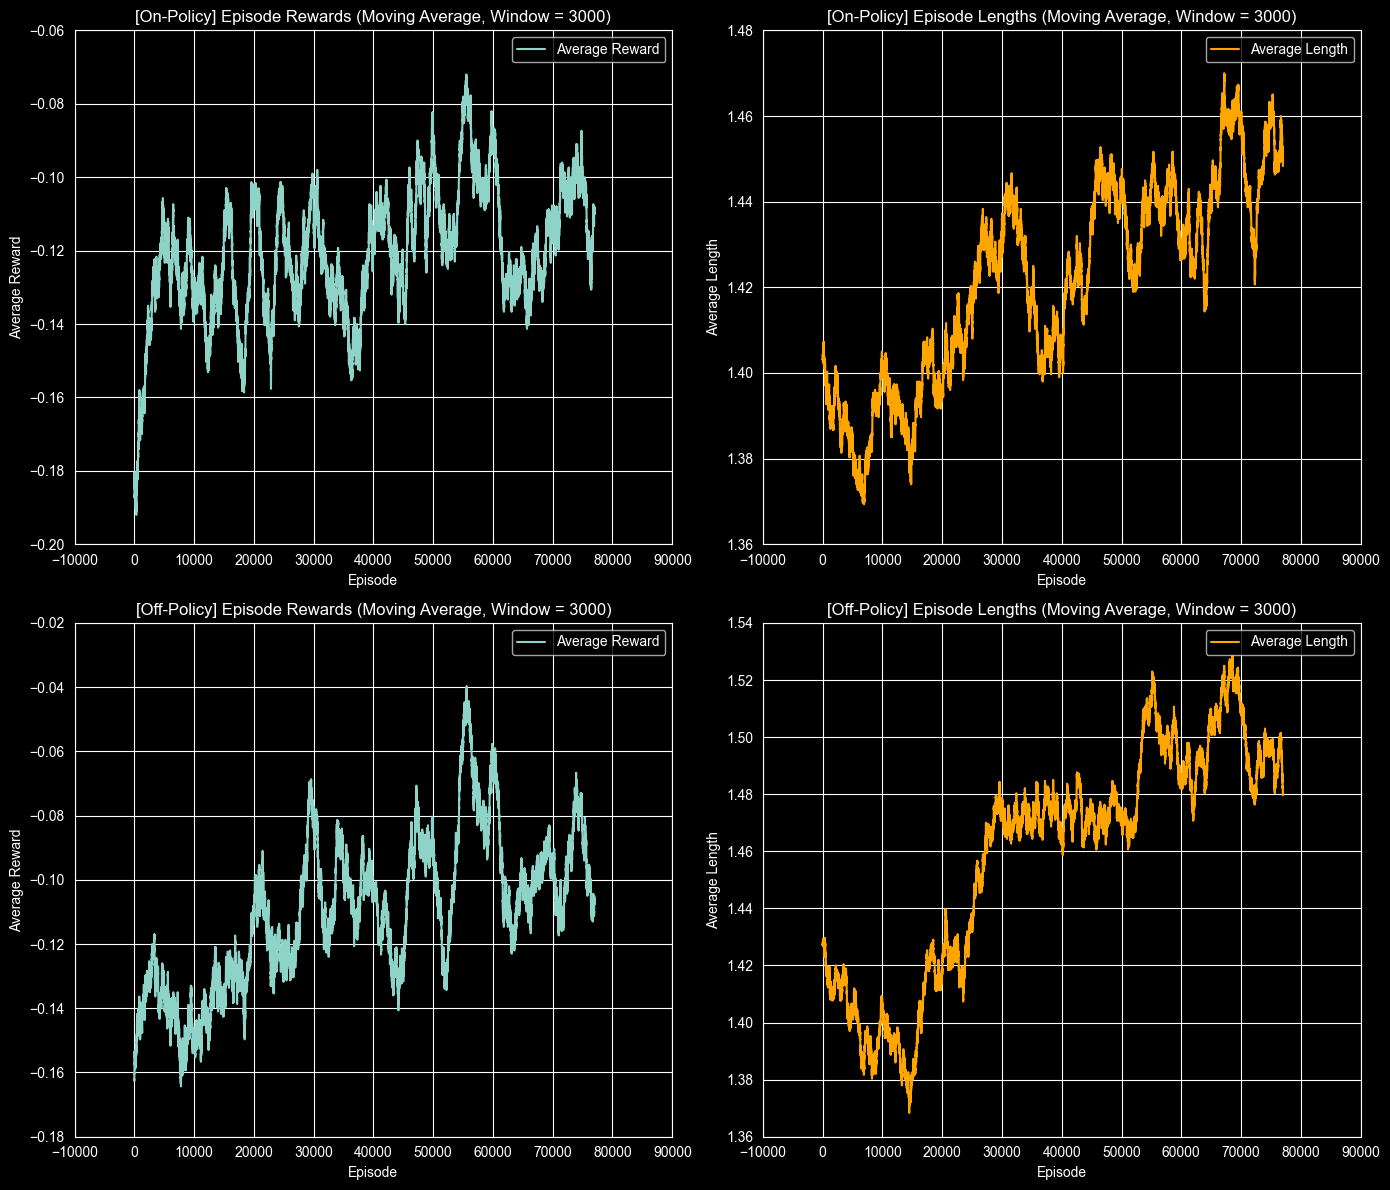

In [21]:
compare_plots(
    plot_rewards,
    agents_data=[(episode_returns_on, episode_lengths_on), (episode_returns_off, episode_lengths_off)],
    agent_names=["On-Policy", "Off-Policy"],
    window=3000  # kwargs opcionales
)

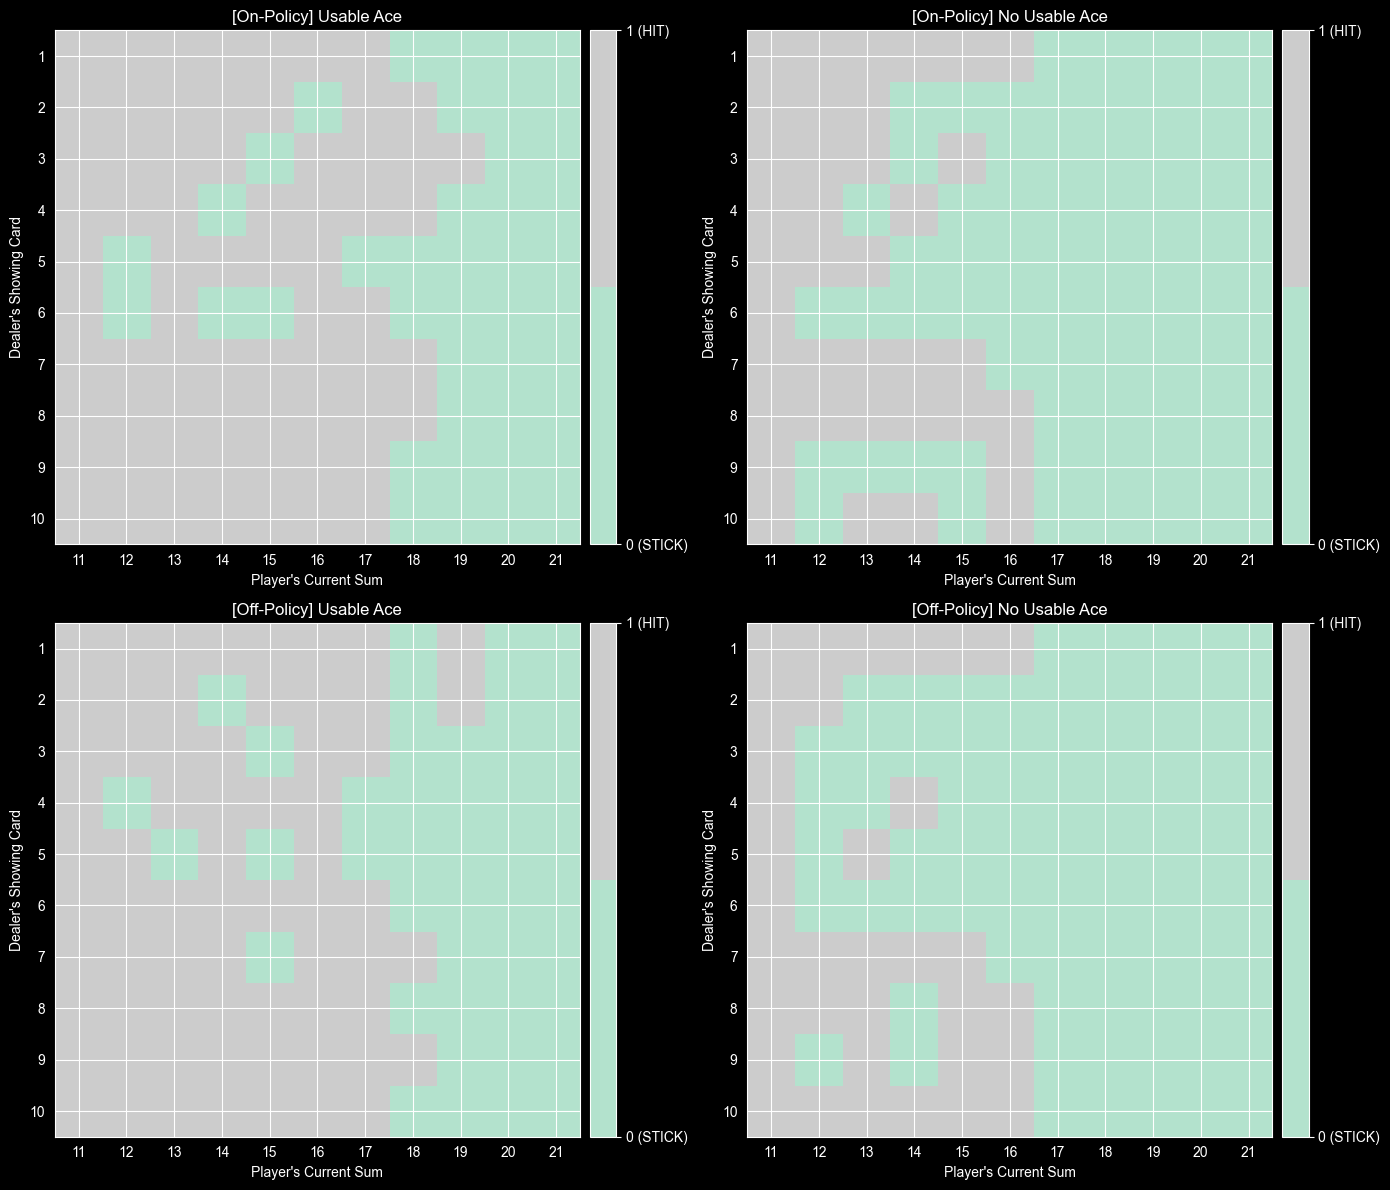

In [22]:
compare_plots(
    plot_policy,
    agents_data=[(policy_on,), (policy_off,)],
    agent_names=["On-Policy", "Off-Policy"]
)

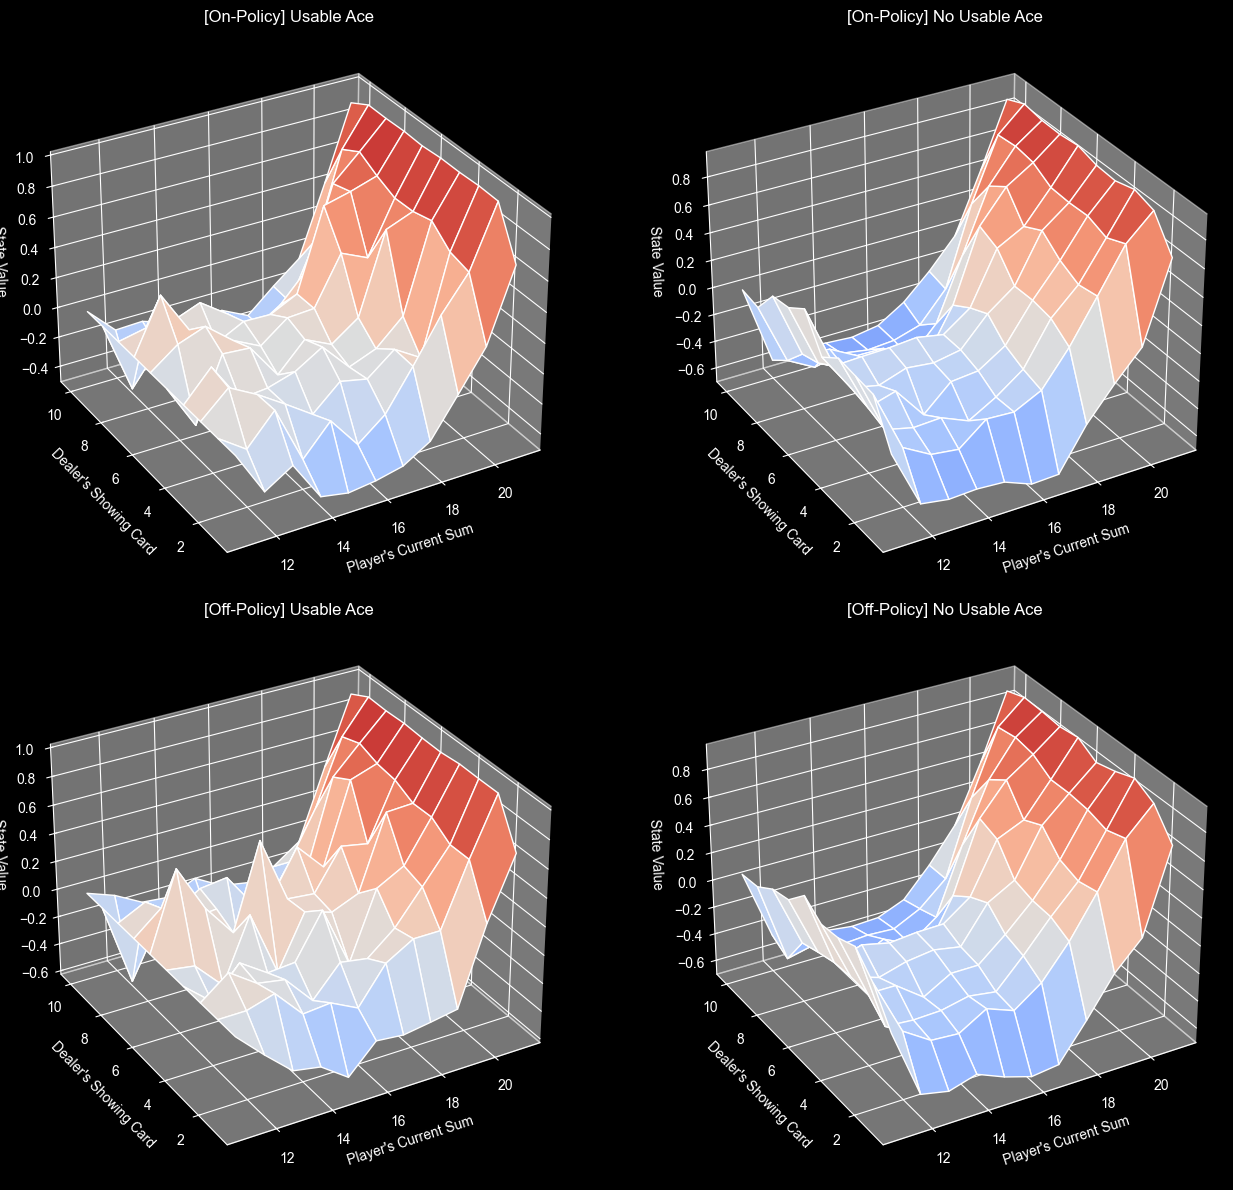

In [23]:
compare_plots(
    plot_blackjack_values,
    agents_data=[(V_on,), (V_off,)],
    agent_names=["On-Policy", "Off-Policy"]
)